In [1]:
import pandas as pd
import numpy as np
import os
from scipy.ndimage import rotate
import scipy.ndimage
from joblib import Parallel, delayed
import multiprocessing
import itertools
import pydicom
import SimpleITK as sitk
from scipy.ndimage import zoom 

#Code from existing github repo provided by UC Irvine dataset
from utils.equalizer import histEq
from utils.utils import cutCube

In [2]:
# Modified DICOM loading functions for newer pydicom versions
def load_scan(path2scan):
    if (path2scan.split('.')[-1] == 'mhd') or (path2scan.split('.')[-1] == 'raw'):
        return load_mhd(path2scan)
    elif path2scan.split('.')[-1] == 'dcm':
        return load_dicom(os.path.split(path2scan)[0]) #pass containing directory
    elif os.path.isdir(path2scan) and any(f.endswith('.dcm') for f in os.listdir(path2scan)):
        return load_dicom(path2scan)
    else:
        raise Exception('No valid scan [series] found in given file/directory')

def load_mhd(path2scan):
    itkimage = sitk.ReadImage(path2scan)
    scan = sitk.GetArrayFromImage(itkimage)
    spacing = np.flip(np.array(itkimage.GetSpacing()),axis=0)
    orientation = np.transpose(np.array(itkimage.GetDirection()).reshape((3, 3)))
    origin = np.flip(np.array(itkimage.GetOrigin()),axis=0)
    return scan, spacing, orientation, origin, None

def load_dicom(path2scan_dir):
    dicom_folder = path2scan_dir
    dcms = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]
    if not dcms:
        raise Exception(f"No DICOM files found in {dicom_folder}")
    
    first_slice_data = pydicom.dcmread(os.path.join(path2scan_dir, dcms[0]))
    first_slice = first_slice_data.pixel_array
    orientation = np.transpose(first_slice_data.ImageOrientationPatient)
    spacing_xy = np.array(first_slice_data.PixelSpacing, dtype=float)
    spacing_z = float(first_slice_data.SliceThickness)
    spacing = np.array([spacing_z, spacing_xy[1], spacing_xy[0]])

    scan = np.zeros((len(dcms), first_slice.shape[0], first_slice.shape[1]))
    raw_slices = []
    indexes = []
    
    for dcm in dcms:
        slice_data = pydicom.dcmread(os.path.join(dicom_folder, dcm))
        slice_data.filename = dcm
        raw_slices.append(slice_data)
        indexes.append(float(slice_data.ImagePositionPatient[2]))
    
    indexes = np.array(indexes, dtype=float)
    raw_slices = [x for _, x in sorted(zip(indexes, raw_slices))]
    
    try:
        origin = np.array(raw_slices[0][0x00200032].value)
        origin = np.array([origin[2], origin[1], origin[0]])
    except:
        origin = np.zeros(3)

    for i, slice_obj in enumerate(raw_slices):
        scan[i, :, :] = slice_obj.pixel_array
    
    return scan, spacing, orientation, origin, raw_slices

def scale_scan(scan, spacing, factor=1):
    resize_factor = factor * spacing
    new_real_shape = scan.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / scan.shape
    new_spacing = spacing / real_resize_factor
    scan_resized = scipy.ndimage.zoom(scan, real_resize_factor, mode='nearest')
    return scan_resized, resize_factor

def get_scaled_shape(shape, spacing):
    new_real_shape = shape * spacing
    return np.round(new_real_shape).astype(int)

def world2vox(world_coord, spacing, orientation, origin):
    world_coord = np.dot(np.linalg.inv(np.dot(orientation, np.diag(spacing))), world_coord - origin)
    if orientation[0, 0] < 0:
        vox_coord = (np.array([world_coord[0], world_coord[2], world_coord[1]])).astype(int)
    else:
        vox_coord = (np.array([world_coord[0], world_coord[1], world_coord[2]])).astype(int)
    return vox_coord

In [3]:
class CombinedLabeledExtractor:
    """
    Extractor that combines multiple experiments into one dataset
    """
    def __init__(self, 
                 experiments_config,  
                 dst_path, 
                 norm_save_dir,
                 cube_shape=(32, 32, 32),
                 parallelize=False,
                 coordSystem='vox',
                 include_types=['FB', 'FM', 'TM'], 
                 augment=True):
        """
        Args:
            experiments_config: List of experiment configurations, each containing:
                - 'labels_csv': Path to labels CSV file
                - 'dicom_dir': Directory containing DICOM files
                - 'experiment_name': Name of the experiment (for tracking)
            dst_path: Where to save the combined processed dataset
            norm_save_dir: Where to save normalization parameters
            cube_shape: Size of extracted 3D cubes
            parallelize: Whether to use multiprocessing
            coordSystem: 'vox' for voxel coordinates
            include_types: Which finding types to include
            augment: Whether to perform data augmentation
        """
        self.experiments_config = experiments_config
        self.dst_path = dst_path
        self.norm_save_dir = norm_save_dir
        self.cube_shape = cube_shape
        self.parallelize = parallelize
        self.coordSystem = coordSystem
        self.include_types = include_types
        self.augment = augment
        
        # Load and combine labels from all experiments
        self.combined_labels_df = pd.DataFrame()
        
        for exp_config in experiments_config:
            print(f"\nLoading labels for {exp_config['experiment_name']}...")
            
            # Load labels for this experiment
            labels_df = pd.read_csv(exp_config['labels_csv'])
            
            # Add experiment identifier
            labels_df['experiment'] = exp_config['experiment_name']
            labels_df['dicom_base_dir'] = exp_config['dicom_dir']
            
            # Filter by type
            labels_df = labels_df[labels_df['type'].isin(include_types)]
            
            # Filter out TB entries with 0,0,0 coordinates
            labels_df = labels_df[~((labels_df['type'] == 'TB') & 
                                   (labels_df['x'] == 0) & 
                                   (labels_df['y'] == 0) & 
                                   (labels_df['slice'] == 0))]
            
            print(f"Loaded {len(labels_df)} samples from {exp_config['experiment_name']}")
            print(f"Types distribution:\n{labels_df['type'].value_counts()}")
            
            # Combine with existing labels
            self.combined_labels_df = pd.concat([self.combined_labels_df, labels_df], 
                                                ignore_index=True)
        
        print(f"\nTotal combined samples: {len(self.combined_labels_df)}")
        print(f"Combined types distribution:\n{self.combined_labels_df['type'].value_counts()}")
        print(f"Samples per experiment:\n{self.combined_labels_df['experiment'].value_counts()}")

    def extract(self, plot=True):
        """Extract and process all labeled samples from all experiments"""
        print("\nPreparing extraction jobs for combined dataset...")
        
        jobs = []
        labels = []
        experiments = []
        
        for idx, row in self.combined_labels_df.iterrows():
            # Build path to DICOM scan using the experiment-specific base directory
            # Handle potential Windows path issues
            scan_path = os.path.join(row['dicom_base_dir'], str(row['uuid']))
            scan_path = os.path.normpath(scan_path)  # Normalize path for Windows)
            
            # Coordinate in z,y,x format (slice, y, x)
            coord = np.array([row['slice'], row['y'], row['x']])
            
            # Job format: [scan_path, coord, cube_shape, coordSystem, label_type]
            jobs.append([scan_path, coord, self.cube_shape, self.coordSystem, row['type']])
            labels.append(row['type'])
            experiments.append(row['experiment'])
        
        print(f"Extracting {len(jobs)} samples from combined dataset...")
        
        if self.parallelize:
            num_cores = int(np.ceil(min(np.ceil(multiprocessing.cpu_count() * 0.75), len(jobs))))
            results = Parallel(n_jobs=num_cores)(delayed(self._process_job)(job) for job in jobs)
        else:
            results = []
            for i, job in enumerate(jobs):
                try:
                    result = self._process_job(job)
                    results.append(result)
                    if i % 10 == 0:
                        print(f"Processed {i+1}/{len(jobs)} samples")
                except Exception as e:
                    print(f"Failed to process sample {job[0]}: {e}")
                    results.append(None)
        
        # Collect successful extractions
        instances = []
        instance_labels = []
        instance_experiments = []
        
        for i, result in enumerate(results):
            if result is not None:
                cubes, label_type = result
                instances.extend(cubes)
                instance_labels.extend([label_type] * len(cubes))
                instance_experiments.extend([experiments[i]] * len(cubes))
        
        instances = np.array(instances)
        instance_labels = np.array(instance_labels)
        instance_experiments = np.array(instance_experiments)
        
        if len(instances) == 0:
            print("ERROR: No instances were successfully extracted!")
            return None, None, None, None
        
        print(f"Successfully extracted {len(instances)} instances")
        print(f"Instances per experiment:")
        unique_exps, counts = np.unique(instance_experiments, return_counts=True)
        for exp, count in zip(unique_exps, counts):
            print(f"  {exp}: {count} instances")
        
        # Preprocessing
        print("\nEqualizing the data...")
        from utils.equalizer import histEq
        eq = histEq(instances)
        instances = eq.equalize(instances)
        os.makedirs(self.norm_save_dir, exist_ok=True)
        eq.save(path=os.path.join(self.norm_save_dir, 'equalization.pkl'))

        print("Normalizing the data...")
        min_v = np.min(instances)
        max_v = np.max(instances)
        mean_v = np.mean(instances)
        norm_data = np.array([mean_v, min_v, max_v])
        instances = (instances - mean_v) / (max_v - min_v)
        np.save(os.path.join(self.norm_save_dir, 'normalization.npy'), norm_data)

        if plot:
            self._plot_samples(instances, instance_labels, instance_experiments)

        # Save dataset, labels, and experiment info
        print("\nSaving the combined dataset...")
        np.save(self.dst_path, instances)
        np.save(self.dst_path.replace('.npy', '_labels.npy'), instance_labels)
        np.save(self.dst_path.replace('.npy', '_experiments.npy'), instance_experiments)
        
        # Save metadata - convert numpy types to Python native types for JSON serialization
        metadata = {
            'label_mapping': {label: int(idx) for idx, label in enumerate(np.unique(instance_labels))},
            'experiment_info': {exp: int(idx) for idx, exp in enumerate(np.unique(instance_experiments))},
            'total_samples': int(len(instances)),
            'samples_per_experiment': {exp: int(count) for exp, count in zip(unique_exps, counts)}
        }
        
        import json
        with open(self.dst_path.replace('.npy', '_metadata.json'), 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"\nLabel mapping: {metadata['label_mapping']}")
        print(f"Experiment mapping: {metadata['experiment_info']}")
        
        return instances, instance_labels, instance_experiments, metadata

    def _process_job(self, args):
        """Process single extraction job"""
        scan_path, coord, cube_shape, coordSystem, label_type = args
        
        try:
            # Debug: Check if path exists
            if not os.path.exists(scan_path):
                print(f"DEBUG: Path does not exist: {scan_path}")
                # Try to list parent directory
                parent_dir = os.path.dirname(scan_path)
                if os.path.exists(parent_dir):
                    print(f"DEBUG: Parent directory contents: {os.listdir(parent_dir)[:5]}")
            
            # Load scan
            scan, spacing, orientation, origin, raw_slices = load_scan(scan_path)
            
            # Convert coordinates if needed
            if coordSystem == 'world':
                coord = world2vox(coord, spacing, orientation, origin)
            
            # Extract the base cube with padding
            from utils.utils import cutCube
            init_cube_shape = get_scaled_shape(np.array(cube_shape) + 8, 1/spacing)
            clean_cube_unscaled = cutCube(scan, coord, init_cube_shape, padd=-1000)
            
            # Scale the cube
            scaled_cube, resize_factor = scale_scan(clean_cube_unscaled, spacing)
            
            # Data augmentation
            if self.augment:
                augmented_cubes = self._augment_instance(scaled_cube)
            else:
                augmented_cubes = [scaled_cube]
            
            # Trim to final shape
            final_cubes = []
            for cube in augmented_cubes:
                center = np.array(cube.shape) // 2
                final_cube = cutCube(cube, center, cube_shape, padd=-1000)
                if final_cube.shape == tuple(cube_shape):
                    final_cubes.append(final_cube)
            
            return final_cubes, label_type
            
        except Exception as e:
            print(f"Error processing {scan_path}: {e}")
            return None

    def _augment_instance(self, x0):
        """Data augmentation"""
        augmented = [x0]  # Original
        
        # Flips
        augmented.append(np.flip(x0, 1))  # x flip
        augmented.append(np.flip(x0, 2))  # y flip
        
        # Small shifts
        augmented.append(scipy.ndimage.shift(x0, (0, 2, 2), mode='constant'))
        augmented.append(scipy.ndimage.shift(x0, (0, -2, 2), mode='constant'))
        
        # Small rotations
        for angle in [15, 30, 45, 90, 180]:
            rotated = rotate(x0, angle, axes=(1, 2), mode='reflect', reshape=False)
            augmented.append(rotated)
        
        # Filter out invalid shapes
        valid_cubes = []
        for cube in augmented:
            if cube.shape[0] > 0 and cube.shape[1] > 0 and cube.shape[2] > 0:
                valid_cubes.append(cube)
        
        return valid_cubes

    def _plot_samples(self, instances, labels, experiments):
        """Plot sample instances with their labels and experiment info"""
        import matplotlib.pyplot as plt
        
        # Get unique combinations of labels and experiments
        unique_labels = np.unique(labels)
        unique_experiments = np.unique(experiments)
        
        # Create a more complex visualization
        samples_per_combo = 3
        
        fig, axes = plt.subplots(len(unique_labels), len(unique_experiments) * samples_per_combo, 
                                figsize=(len(unique_experiments) * samples_per_combo * 3, 
                                        len(unique_labels) * 3))
        
        if len(unique_labels) == 1:
            axes = axes.reshape(1, -1)
        if len(unique_experiments) == 1:
            axes = axes.reshape(-1, samples_per_combo)
        
        for i, label in enumerate(unique_labels):
            for j, exp in enumerate(unique_experiments):
                # Find samples matching this label and experiment
                mask = (labels == label) & (experiments == exp)
                matching_indices = np.where(mask)[0]
                
                if len(matching_indices) > 0:
                    selected_indices = np.random.choice(matching_indices, 
                                                      min(samples_per_combo, len(matching_indices)), 
                                                      replace=False)
                    
                    for k, idx in enumerate(selected_indices):
                        ax_idx = j * samples_per_combo + k
                        middle_slice = instances[idx].shape[0] // 2
                        axes[i, ax_idx].imshow(instances[idx][middle_slice, :, :], cmap='bone')
                        axes[i, ax_idx].set_title(f'{label} - {exp}')
                        axes[i, ax_idx].axis('off')
                else:
                    # No samples for this combination
                    for k in range(samples_per_combo):
                        ax_idx = j * samples_per_combo + k
                        axes[i, ax_idx].text(0.5, 0.5, 'No samples', 
                                           ha='center', va='center', 
                                           transform=axes[i, ax_idx].transAxes)
                        axes[i, ax_idx].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Sample Extracted Instances by Type and Experiment')
        plt.show()


In [4]:
class CombinedDataLoader:
    """
    Data loader for combined dataset with experiment tracking
    """
    def __init__(self, dataset_path, labels_path, experiments_path, metadata_path, normdata_path, img_res=(32, 32, 32)):
        self.normdata_path = normdata_path
        self.img_res = img_res
        
        print("Loading combined preprocessed dataset...")
        self.data = np.load(dataset_path)
        self.labels = np.load(labels_path)
        self.experiments = np.load(experiments_path)
        
        # Load metadata
        import json
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)
        
        # Create label mapping
        self.label_to_idx = self.metadata['label_mapping']
        self.idx_to_label = {int(idx): label for label, idx in self.label_to_idx.items()}
        
        # Create experiment mapping
        self.experiment_to_idx = self.metadata['experiment_info']
        self.idx_to_experiment = {int(idx): exp for exp, idx in self.experiment_to_idx.items()}
        
        # Convert labels to indices
        self.label_indices = np.array([self.label_to_idx[label] for label in self.labels])
        self.experiment_indices = np.array([self.experiment_to_idx[exp] for exp in self.experiments])
        
        # Format for neural network
        self.data = self.data.reshape((len(self.data), self.img_res[0], self.img_res[1], self.img_res[2], 1))
        
        print(f"Loaded {len(self.data)} samples from combined dataset")
        print(f"Label distribution: {dict(zip(*np.unique(self.labels, return_counts=True)))}")
        print(f"Experiment distribution: {dict(zip(*np.unique(self.experiments, return_counts=True)))}")

    def load_batch(self, batch_size=32, shuffle=True, experiment_filter=None):
        """
        Load batches for training with optional experiment filtering
        
        Args:
            batch_size: Size of each batch
            shuffle: Whether to shuffle the data
            experiment_filter: If provided, only load data from specified experiment(s)
        """
        # Filter by experiment if requested
        if experiment_filter is not None:
            if isinstance(experiment_filter, str):
                experiment_filter = [experiment_filter]
            
            mask = np.isin(self.experiments, experiment_filter)
            filtered_indices = np.where(mask)[0]
        else:
            filtered_indices = np.arange(len(self.data))
        
        if shuffle:
            indices = np.random.permutation(filtered_indices)
        else:
            indices = filtered_indices
        
        n_batches = len(indices) // batch_size
        
        for i in range(n_batches):
            batch_indices = indices[i * batch_size:(i + 1) * batch_size]
            batch_data = self.data[batch_indices]
            batch_labels = self.label_indices[batch_indices]
            batch_experiments = self.experiment_indices[batch_indices]
            
            yield batch_data, batch_labels, batch_experiments

    def get_train_test_split(self, test_size=0.2, stratify_by='both', random_state=42):
        """
        Create train/test split with stratification options
        
        Args:
            test_size: Proportion of data for testing
            stratify_by: 'labels', 'experiments', 'both', or None
            random_state: Random seed for reproducibility
        """
        from sklearn.model_selection import train_test_split
        
        indices = np.arange(len(self.data))
        
        if stratify_by == 'labels':
            stratify = self.label_indices
        elif stratify_by == 'experiments':
            stratify = self.experiment_indices
        elif stratify_by == 'both':
            # Create combined stratification key
            stratify = [f"{l}_{e}" for l, e in zip(self.label_indices, self.experiment_indices)]
        else:
            stratify = None
        
        train_idx, test_idx = train_test_split(
            indices, 
            test_size=test_size, 
            stratify=stratify, 
            random_state=random_state
        )
        
        return train_idx, test_idx


Loading labels for Experiment_1...
Loaded 118 samples from Experiment_1
Types distribution:
type
FB    61
FM    34
TM    23
Name: count, dtype: int64

Loading labels for Experiment_2...
Loaded 30 samples from Experiment_2
Types distribution:
type
TM    12
FB    11
FM     7
Name: count, dtype: int64

Total combined samples: 148
Combined types distribution:
type
FB    72
FM    41
TM    35
Name: count, dtype: int64
Samples per experiment:
experiment
Experiment_1    118
Experiment_2     30
Name: count, dtype: int64

Preparing extraction jobs for combined dataset...
Extracting 148 samples from combined dataset...
Processed 1/148 samples
Processed 11/148 samples
Processed 21/148 samples
Processed 31/148 samples
Processed 41/148 samples
Processed 51/148 samples
Processed 61/148 samples
Processed 71/148 samples
Processed 81/148 samples
Processed 91/148 samples
Processed 101/148 samples
Processed 111/148 samples
Processed 121/148 samples
Processed 131/148 samples
Processed 141/148 samples
Succ

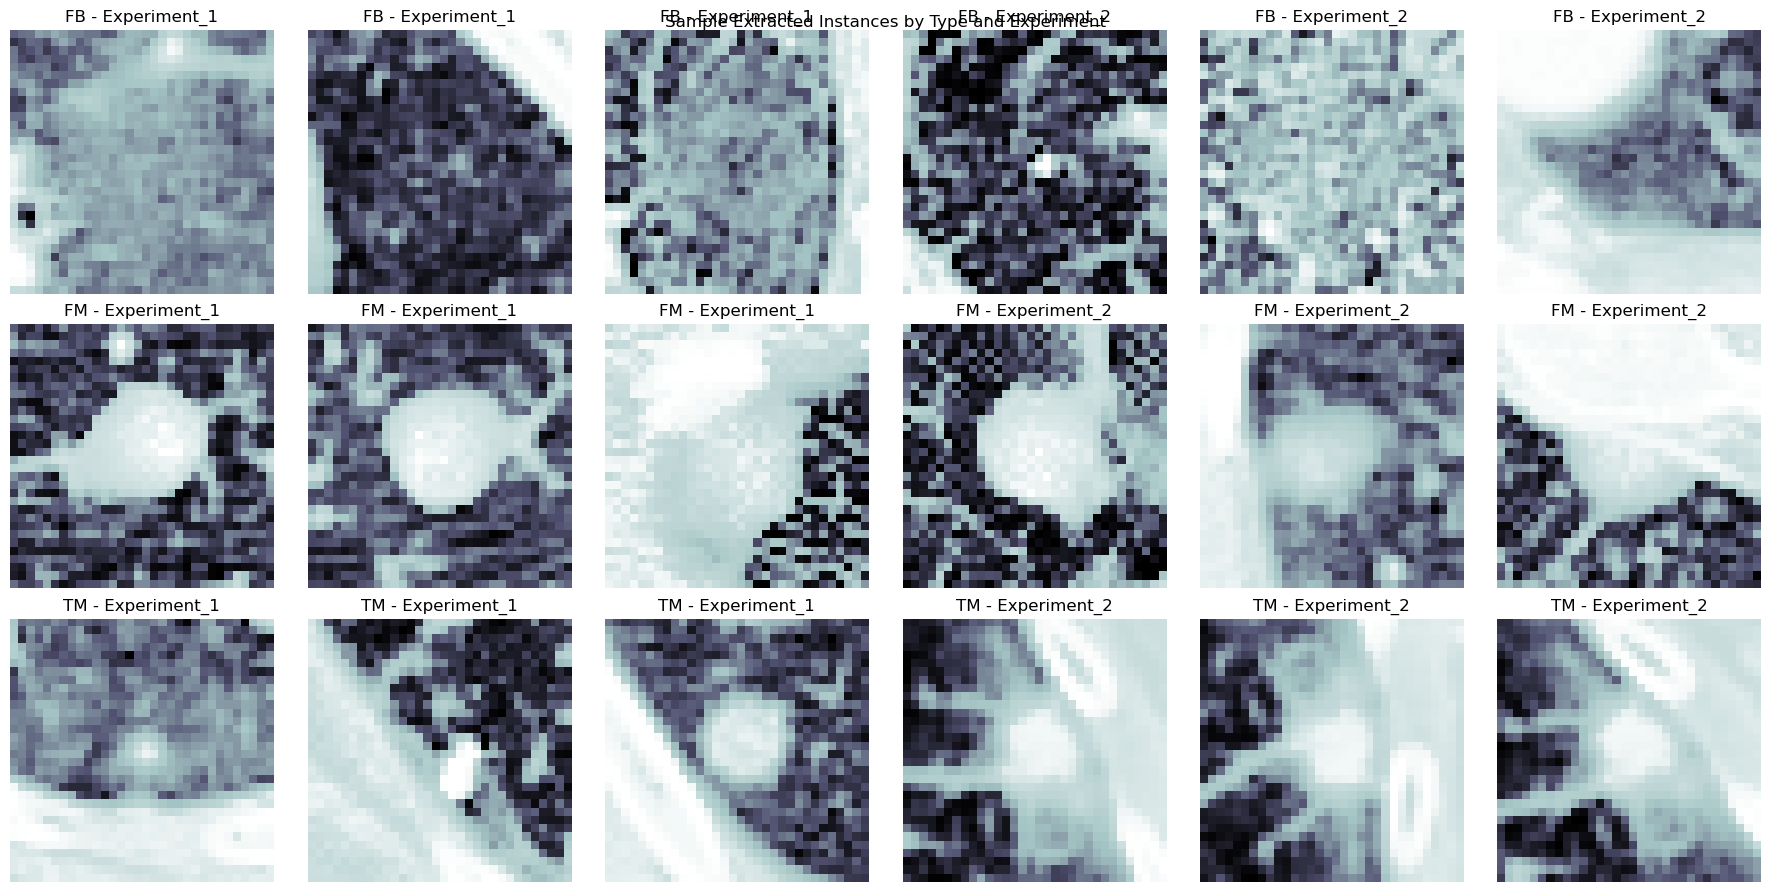


Saving the combined dataset...

Label mapping: {'FB': 0, 'FM': 1, 'TM': 2}
Experiment mapping: {'Experiment_1': 0, 'Experiment_2': 1}
Loading combined preprocessed dataset...
Loaded 1480 samples from combined dataset
Label distribution: {'FB': 720, 'FM': 410, 'TM': 350}
Experiment distribution: {'Experiment_1': 1180, 'Experiment_2': 300}

Train/Test split: 1184 train samples, 296 test samples


In [5]:
if __name__ == "__main__":
    # Configuration for combined dataset
    base_path = os.path.expanduser("~/Downloads/deepfakes+medical+image+tamper+detection (1)/data/Tampered Scans/")
    
    # Define experiments configuration
    experiments_config = [
        {
            'labels_csv': os.path.join(base_path, "labels_exp1.csv"),
            'dicom_dir': os.path.join(base_path, "Experiment 1 - Blind"),
            'experiment_name': 'Experiment_1'
        },
        {
            'labels_csv': os.path.join(base_path, "labels_exp2.csv"),
            'dicom_dir': os.path.join(base_path, "Experiment 2 - Open"),
            'experiment_name': 'Experiment_2'
        }
    ]
    
    output_dataset = "combined_tampered_scans_dataset.npy"
    normalization_dir = "combined_tampered_scans_normalization"
    
    # Extract and preprocess combined dataset
    extractor = CombinedLabeledExtractor(
        experiments_config=experiments_config,
        dst_path=output_dataset,
        norm_save_dir=normalization_dir,
        cube_shape=(32, 32, 32),
        include_types=['FB', 'FM', 'TM'], 
        augment=True,
        parallelize=False
    )
    
    instances, labels, experiments, metadata = extractor.extract()
    
    # Load combined dataset for training
    if instances is not None:
        dataloader = CombinedDataLoader(
            dataset_path=output_dataset,
            labels_path=output_dataset.replace('.npy', '_labels.npy'),
            experiments_path=output_dataset.replace('.npy', '_experiments.npy'),
            metadata_path=output_dataset.replace('.npy', '_metadata.json'),
            normdata_path=normalization_dir
        )
        
        # Create train/test split
        train_idx, test_idx = dataloader.get_train_test_split(test_size=0.2, stratify_by='both')
        print(f"\nTrain/Test split: {len(train_idx)} train samples, {len(test_idx)} test samples")

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import json

def create_combined_eda_dataframe(experiments_config, processed_data_path=None, 
                                 processed_labels_path=None, processed_experiments_path=None,
                                 metadata_path=None):
    """
    Create dataframe for EDA from combined experiments
    """
    # Load and combine labels from all experiments
    combined_df = pd.DataFrame()
    
    for exp_config in experiments_config:
        print(f"\nLoading labels for {exp_config['experiment_name']}...")
        
        # Load labels for this experiment
        df_exp = pd.read_csv(exp_config['labels_csv'])
        df_exp['experiment'] = exp_config['experiment_name']
        
        # Filter types
        df_exp = df_exp[df_exp['type'].isin(['FB', 'FM', 'TM'])]
        df_exp = df_exp[~((df_exp['type'] == 'TB') & 
                         (df_exp['x'] == 0) & 
                         (df_exp['y'] == 0) & 
                         (df_exp['slice'] == 0))]
        
        print(f"  {exp_config['experiment_name']}: {len(df_exp)} instances after filtering")
        
        combined_df = pd.concat([combined_df, df_exp], ignore_index=True)
    
    print(f"\nTotal combined instances: {len(combined_df)}")
    
    # Add encoded labels
    le = LabelEncoder()
    combined_df['type_encoded'] = le.fit_transform(combined_df['type'])
    
    # Add augmentation info if processed data available
    if processed_data_path and processed_labels_path:
        try:
            processed_labels = np.load(processed_labels_path)
            if processed_experiments_path:
                processed_experiments = np.load(processed_experiments_path)
            
            print(f"Processed dataset size: {len(processed_labels)}")
            
            # Calculate overall augmentation factor
            augmentation_factor = len(processed_labels) / len(combined_df)
            combined_df['augmentation_factor'] = augmentation_factor
            
            # Load metadata if available
            if metadata_path:
                with open(metadata_path, 'r') as f:
                    metadata = json.load(f)
                    combined_df['metadata'] = str(metadata)
            
        except FileNotFoundError:
            print("Processed data not found, using original data only")
            combined_df['augmentation_factor'] = 1
    
    return combined_df, le

def plot_combined_class_distribution(df):
    """Create class distribution bar plot with experiment breakdown"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Overall distribution
    class_counts = df['type'].value_counts()
    classes = class_counts.index
    counts = class_counts.values
    
    colors = {'FB': '#FF6B6B', 'FM': '#4ECDC4', 'TM': '#45B7D1'}
    plot_colors = [colors[cls] for cls in classes]
    
    # Plot 1: Overall distribution
    bars = axes[0].bar(classes, counts, color=plot_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    axes[0].set_title('Overall Distribution of Tamper Types', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Tamper Classification', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
    
    # Add value labels
    for bar, count in zip(bars, counts):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(count), ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Add percentage labels
    total = sum(counts)
    for bar, count in zip(bars, counts):
        percentage = (count/total) * 100
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
                    f'{percentage:.1f}%', ha='center', va='center', 
                    fontweight='bold', fontsize=10, color='white')
    
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Distribution by experiment
    exp_type_counts = df.groupby(['experiment', 'type']).size().unstack(fill_value=0)
    
    x = np.arange(len(exp_type_counts.index))
    width = 0.25
    
    for i, tamper_type in enumerate(['FB', 'FM', 'TM']):
        if tamper_type in exp_type_counts.columns:
            values = exp_type_counts[tamper_type]
            axes[1].bar(x + i*width, values, width, label=tamper_type, 
                       color=colors[tamper_type], alpha=0.8, edgecolor='black')
            
            # Add value labels
            for j, v in enumerate(values):
                if v > 0:
                    axes[1].text(j + i*width, v + 0.5, str(v), 
                               ha='center', va='bottom', fontsize=9)
    
    axes[1].set_xlabel('Experiment', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
    axes[1].set_title('Distribution by Experiment', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x + width)
    axes[1].set_xticklabels(exp_type_counts.index)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n=== Combined Dataset Statistics ===")
    print(f"Total instances: {len(df)}")
    print(f"\nOverall class distribution:")
    for cls in classes:
        count = class_counts[cls]
        pct = (count/total) * 100
        print(f"  {cls}: {count} instances ({pct:.1f}%)")
    
    print(f"\nDistribution by experiment:")
    for exp in df['experiment'].unique():
        exp_df = df[df['experiment'] == exp]
        print(f"\n{exp} ({len(exp_df)} total):")
        exp_counts = exp_df['type'].value_counts()
        for cls, count in exp_counts.items():
            pct = (count/len(exp_df)) * 100
            print(f"  {cls}: {count} ({pct:.1f}%)")

def plot_experiment_comparison(df):
    """Compare characteristics between experiments"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    experiments = df['experiment'].unique()
    
    # 1. Spatial distribution comparison - X coordinate
    for exp in experiments:
        exp_data = df[df['experiment'] == exp]
        axes[0, 0].hist(exp_data['x'], bins=20, alpha=0.6, label=exp, density=True)
    axes[0, 0].set_xlabel('X Coordinate', fontweight='bold')
    axes[0, 0].set_ylabel('Density', fontweight='bold')
    axes[0, 0].set_title('X Coordinate Distribution by Experiment', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Y coordinate
    for exp in experiments:
        exp_data = df[df['experiment'] == exp]
        axes[0, 1].hist(exp_data['y'], bins=20, alpha=0.6, label=exp, density=True)
    axes[0, 1].set_xlabel('Y Coordinate', fontweight='bold')
    axes[0, 1].set_ylabel('Density', fontweight='bold')
    axes[0, 1].set_title('Y Coordinate Distribution by Experiment', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Slice distribution
    for exp in experiments:
        exp_data = df[df['experiment'] == exp]
        axes[1, 0].hist(exp_data['slice'], bins=20, alpha=0.6, label=exp, density=True)
    axes[1, 0].set_xlabel('Slice Number', fontweight='bold')
    axes[1, 0].set_ylabel('Density', fontweight='bold')
    axes[1, 0].set_title('Slice Distribution by Experiment', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Unique patients per experiment
    patient_stats = []
    for exp in experiments:
        exp_data = df[df['experiment'] == exp]
        unique_patients = exp_data['uuid'].nunique()
        total_instances = len(exp_data)
        patient_stats.append([exp, unique_patients, total_instances])
    
    patient_df = pd.DataFrame(patient_stats, columns=['Experiment', 'Unique Patients', 'Total Instances'])
    
    x = np.arange(len(experiments))
    width = 0.35
    
    axes[1, 1].bar(x - width/2, patient_df['Unique Patients'], width, 
                   label='Unique Patients', alpha=0.8)
    axes[1, 1].bar(x + width/2, patient_df['Total Instances'], width, 
                   label='Total Instances', alpha=0.8)
    
    axes[1, 1].set_xlabel('Experiment', fontweight='bold')
    axes[1, 1].set_ylabel('Count', fontweight='bold')
    axes[1, 1].set_title('Patients and Instances by Experiment', fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(experiments)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add value labels
    for i, (patients, instances) in enumerate(zip(patient_df['Unique Patients'], 
                                                  patient_df['Total Instances'])):
        axes[1, 1].text(i - width/2, patients + 0.5, str(patients), 
                       ha='center', va='bottom', fontsize=9)
        axes[1, 1].text(i + width/2, instances + 0.5, str(instances), 
                       ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison statistics
    print("\n=== Experiment Comparison ===")
    for exp in experiments:
        exp_data = df[df['experiment'] == exp]
        print(f"\n{exp}:")
        print(f"  Total instances: {len(exp_data)}")
        print(f"  Unique patients: {exp_data['uuid'].nunique()}")
        print(f"  Avg instances per patient: {len(exp_data)/exp_data['uuid'].nunique():.2f}")
        print(f"  Spatial ranges:")
        for coord in ['x', 'y', 'slice']:
            print(f"    {coord}: [{exp_data[coord].min()}-{exp_data[coord].max()}], "
                  f"mean={exp_data[coord].mean():.1f}±{exp_data[coord].std():.1f}")

def plot_combined_spatial_distribution(df):
    """Create spatial distribution with experiment coloring"""
    fig = plt.figure(figsize=(18, 12))
    
    # Create color mapping
    exp_colors = {'Experiment_1': 'blue', 'Experiment_2': 'red'}
    type_markers = {'FB': 'o', 'FM': 's', 'TM': '^'}
    
    # 3D scatter plot
    ax1 = fig.add_subplot(221, projection='3d')
    
    for exp in df['experiment'].unique():
        for ttype in df['type'].unique():
            subset = df[(df['experiment'] == exp) & (df['type'] == ttype)]
            if len(subset) > 0:
                ax1.scatter(subset['x'], subset['y'], subset['slice'], 
                           c=exp_colors.get(exp, 'gray'), 
                           marker=type_markers.get(ttype, 'o'),
                           s=50, alpha=0.6, 
                           label=f'{exp}-{ttype}' if len(df['experiment'].unique()) * len(df['type'].unique()) <= 6 else None)
    
    ax1.set_xlabel('X Coordinate', fontweight='bold')
    ax1.set_ylabel('Y Coordinate', fontweight='bold')
    ax1.set_zlabel('Slice Number', fontweight='bold')
    ax1.set_title('3D Spatial Distribution by Experiment and Type', fontsize=14, fontweight='bold')
    if len(df['experiment'].unique()) * len(df['type'].unique()) <= 6:
        ax1.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
    
    # 2D projections
    # X-Y plane
    ax2 = fig.add_subplot(222)
    for exp in df['experiment'].unique():
        exp_data = df[df['experiment'] == exp]
        ax2.scatter(exp_data['x'], exp_data['y'], 
                   c=exp_colors.get(exp, 'gray'), 
                   alpha=0.6, s=30, label=exp)
    ax2.set_xlabel('X Coordinate', fontweight='bold')
    ax2.set_ylabel('Y Coordinate', fontweight='bold')
    ax2.set_title('X-Y Plane Distribution by Experiment', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # X-Z plane
    ax3 = fig.add_subplot(223)
    for exp in df['experiment'].unique():
        exp_data = df[df['experiment'] == exp]
        ax3.scatter(exp_data['x'], exp_data['slice'], 
                   c=exp_colors.get(exp, 'gray'), 
                   alpha=0.6, s=30, label=exp)
    ax3.set_xlabel('X Coordinate', fontweight='bold')
    ax3.set_ylabel('Slice Number', fontweight='bold')
    ax3.set_title('X-Z Plane Distribution by Experiment', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Y-Z plane
    ax4 = fig.add_subplot(224)
    for exp in df['experiment'].unique():
        exp_data = df[df['experiment'] == exp]
        ax4.scatter(exp_data['y'], exp_data['slice'], 
                   c=exp_colors.get(exp, 'gray'), 
                   alpha=0.6, s=30, label=exp)
    ax4.set_xlabel('Y Coordinate', fontweight='bold')
    ax4.set_ylabel('Slice Number', fontweight='bold')
    ax4.set_title('Y-Z Plane Distribution by Experiment', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def visualize_augmented_samples(augmented_data_path, labels_path, experiments_path, metadata_path):
    """Visualize augmented samples from combined dataset"""
    try:
        augmented_data = np.load(augmented_data_path)
        labels = np.load(labels_path)
        experiments = np.load(experiments_path)
        
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        # Get unique combinations
        unique_labels = np.unique(labels)
        unique_experiments = np.unique(experiments)
        
        # Create figure
        rows = len(unique_labels)
        cols = min(6, len(unique_experiments) * 3)  # 3 samples per experiment
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        
        if rows == 1:
            axes = axes.reshape(1, -1)
        if cols == 1:
            axes = axes.reshape(-1, 1)
        
        for label_idx, label in enumerate(unique_labels):
            col_idx = 0
            for exp in unique_experiments:
                # Find samples matching this label and experiment
                mask = (labels == label) & (experiments == exp)
                matching_indices = np.where(mask)[0]
                
                if len(matching_indices) > 0:
                    # Show up to 3 samples
                    for sample_num in range(min(3, len(matching_indices))):
                        if col_idx < cols:
                            sample_idx = matching_indices[sample_num]
                            sample_cube = augmented_data[sample_idx]
                            middle_slice = sample_cube.shape[0] // 2
                            
                            axes[label_idx, col_idx].imshow(sample_cube[middle_slice, :, :], cmap='bone')
                            axes[label_idx, col_idx].set_title(f'{label}-{exp}-{sample_num+1}', fontsize=8)
                            axes[label_idx, col_idx].axis('off')
                            col_idx += 1
            
            # Fill remaining columns
            while col_idx < cols:
                axes[label_idx, col_idx].axis('off')
                col_idx += 1
        
        plt.suptitle('Augmented Samples by Type and Experiment', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Print augmentation statistics
        print("\n=== Augmentation Statistics ===")
        print(f"Total augmented samples: {len(augmented_data)}")
        print(f"Samples per experiment:")
        for exp in unique_experiments:
            exp_count = np.sum(experiments == exp)
            print(f"  {exp}: {exp_count} samples")
        print(f"\nAugmentation factor per type:")
        for label in unique_labels:
            label_count = np.sum(labels == label)
            # Estimate original count from metadata
            orig_count = metadata['label_mapping'].get(label, 1)
            print(f"  {label}: {label_count} samples")
            
    except Exception as e:
        print(f"Could not load augmented data: {e}")

def run_combined_eda(experiments_config, output_dataset_path=None):
    """
    Run complete EDA pipeline for combined dataset
    """
    print("=== COMBINED DATASET EDA - MEDICAL IMAGE TAMPER DETECTION ===\n")
    
    # Prepare paths
    processed_data_path = output_dataset_path
    processed_labels_path = output_dataset_path.replace('.npy', '_labels.npy') if output_dataset_path else None
    processed_experiments_path = output_dataset_path.replace('.npy', '_experiments.npy') if output_dataset_path else None
    metadata_path = output_dataset_path.replace('.npy', '_metadata.json') if output_dataset_path else None
    
    # Create combined dataframe
    df, label_encoder = create_combined_eda_dataframe(
        experiments_config, 
        processed_data_path,
        processed_labels_path,
        processed_experiments_path,
        metadata_path
    )
    
    print(f"\nCombined dataset loaded successfully!")
    print(f"Total instances: {len(df)}")
    print(f"Unique patients: {df['uuid'].nunique()}")
    print(f"Experiments: {df['experiment'].unique()}")
    print(f"Tamper types: {df['type'].unique()}")
    
    # Run all visualizations
    print("\n" + "="*50)
    print("1. COMBINED CLASS DISTRIBUTION ANALYSIS")
    print("="*50)
    plot_combined_class_distribution(df)
    
    print("\n" + "="*50)
    print("2. EXPERIMENT COMPARISON")
    print("="*50)
    plot_experiment_comparison(df)
    
    print("\n" + "="*50)
    print("3. COMBINED SPATIAL DISTRIBUTION")
    print("="*50)
    plot_combined_spatial_distribution(df)
    
    print("\n" + "="*50)
    print("4. CORRELATION ANALYSIS")
    print("="*50)
    from matplotlib import pyplot as plt
    # Reuse the correlation analysis from original
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    coords = ['x', 'y', 'slice']
    corr_matrix = df[coords].corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, ax=axes[0], cbar_kws={'label': 'Correlation Coefficient'})
    axes[0].set_title('Spatial Coordinate Correlations (Combined)', fontsize=14, fontweight='bold')
    
    # Correlation by experiment
    exp1_df = df[df['experiment'] == 'Experiment_1']
    exp2_df = df[df['experiment'] == 'Experiment_2']
    
    axes[1].scatter(exp1_df['x'], exp1_df['y'], alpha=0.6, s=30, label='Experiment 1')
    axes[1].scatter(exp2_df['x'], exp2_df['y'], alpha=0.6, s=30, label='Experiment 2')
    axes[1].set_xlabel('X Coordinate', fontweight='bold')
    axes[1].set_ylabel('Y Coordinate', fontweight='bold')
    axes[1].set_title('X-Y Relationship by Experiment', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show augmented samples if available
    if output_dataset_path and all([processed_data_path, processed_labels_path, 
                                   processed_experiments_path, metadata_path]):
        print("\n" + "="*50)
        print("5. AUGMENTED SAMPLES VISUALIZATION")
        print("="*50)
        visualize_augmented_samples(processed_data_path, processed_labels_path, 
                                   processed_experiments_path, metadata_path)
    
    return df, label_encoder

=== COMBINED DATASET EDA - MEDICAL IMAGE TAMPER DETECTION ===


Loading labels for Experiment_1...
  Experiment_1: 118 instances after filtering

Loading labels for Experiment_2...
  Experiment_2: 30 instances after filtering

Total combined instances: 148
Processed dataset size: 1480

Combined dataset loaded successfully!
Total instances: 148
Unique patients: 83
Experiments: ['Experiment_1' 'Experiment_2']
Tamper types: ['FB' 'FM' 'TM']

1. COMBINED CLASS DISTRIBUTION ANALYSIS


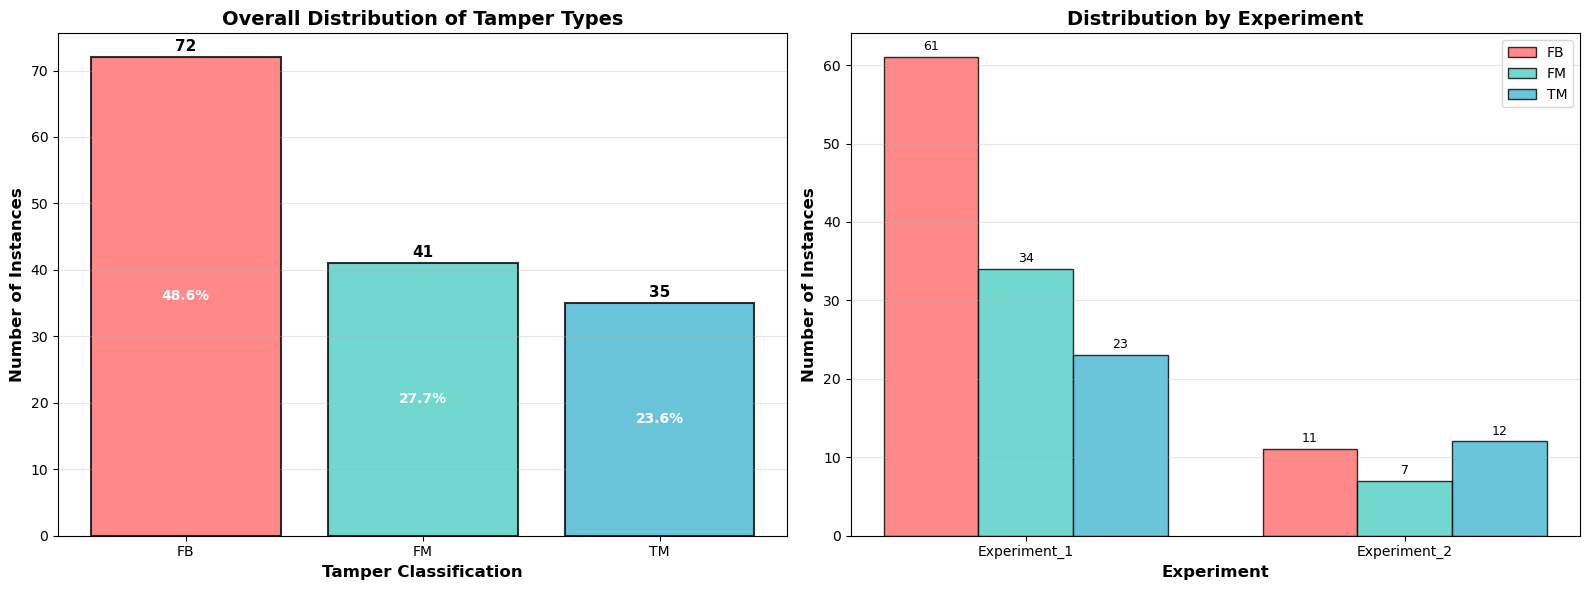


=== Combined Dataset Statistics ===
Total instances: 148

Overall class distribution:
  FB: 72 instances (48.6%)
  FM: 41 instances (27.7%)
  TM: 35 instances (23.6%)

Distribution by experiment:

Experiment_1 (118 total):
  FB: 61 (51.7%)
  FM: 34 (28.8%)
  TM: 23 (19.5%)

Experiment_2 (30 total):
  TM: 12 (40.0%)
  FB: 11 (36.7%)
  FM: 7 (23.3%)

2. EXPERIMENT COMPARISON


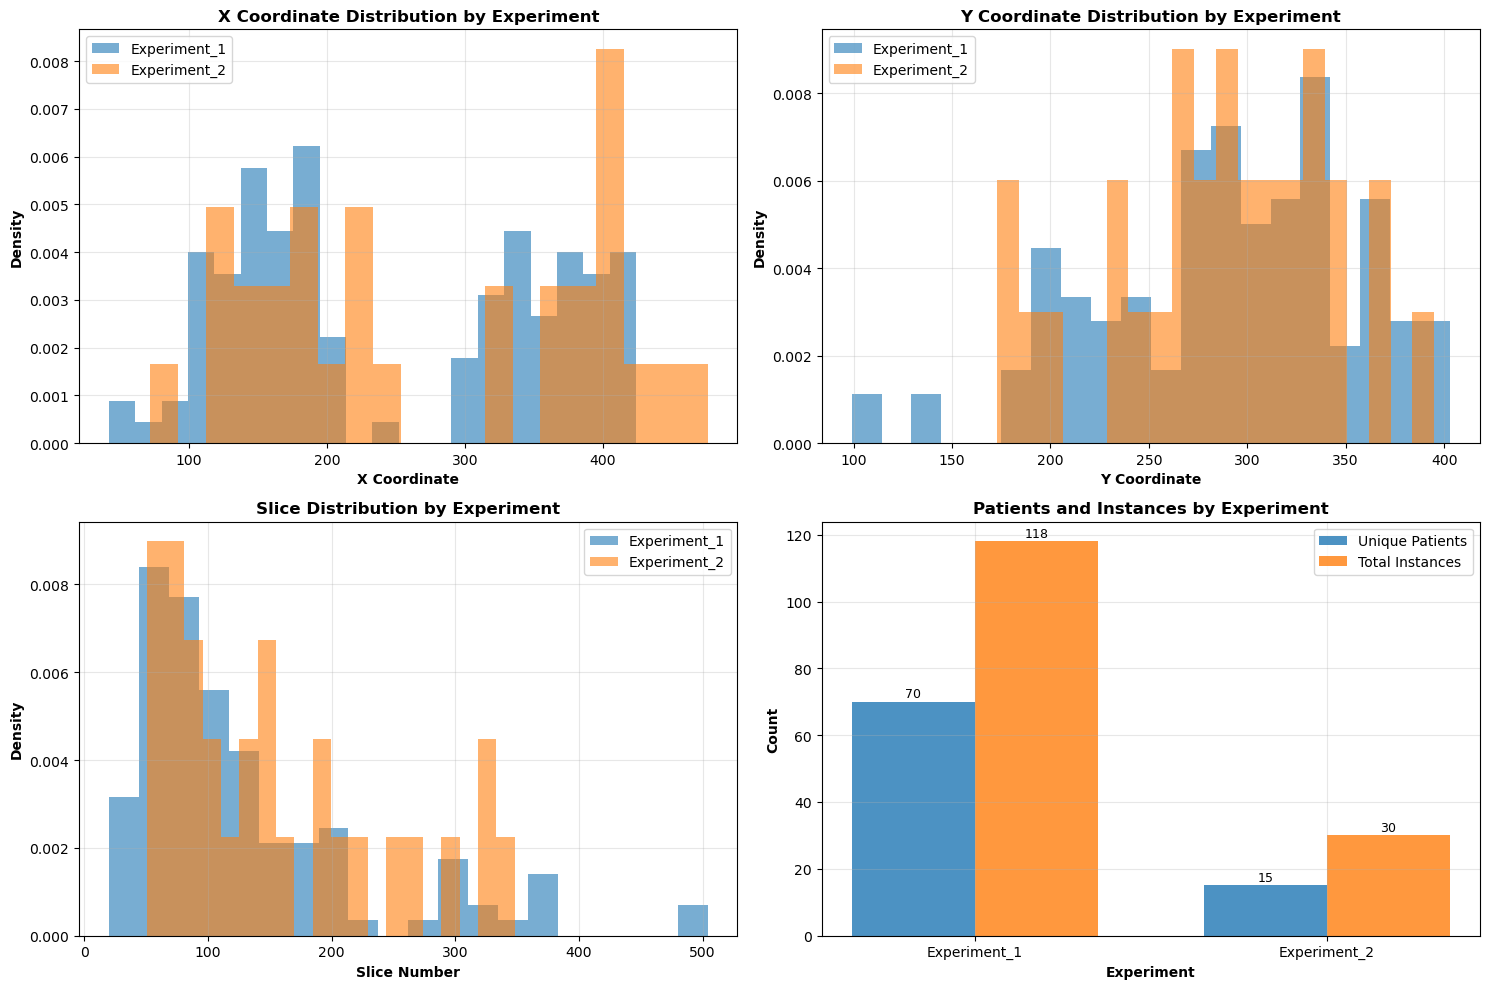


=== Experiment Comparison ===

Experiment_1:
  Total instances: 118
  Unique patients: 70
  Avg instances per patient: 1.69
  Spatial ranges:
    x: [42-424], mean=245.3±112.6
    y: [99-403], mean=288.9±65.2
    slice: [20-504], mean=131.0±98.7

Experiment_2:
  Total instances: 30
  Unique patients: 15
  Avg instances per patient: 2.00
  Spatial ranges:
    x: [72-476], mean=274.7±121.8
    y: [173-395], mean=287.5±56.2
    slice: [51-348], mean=153.3±89.4

3. COMBINED SPATIAL DISTRIBUTION


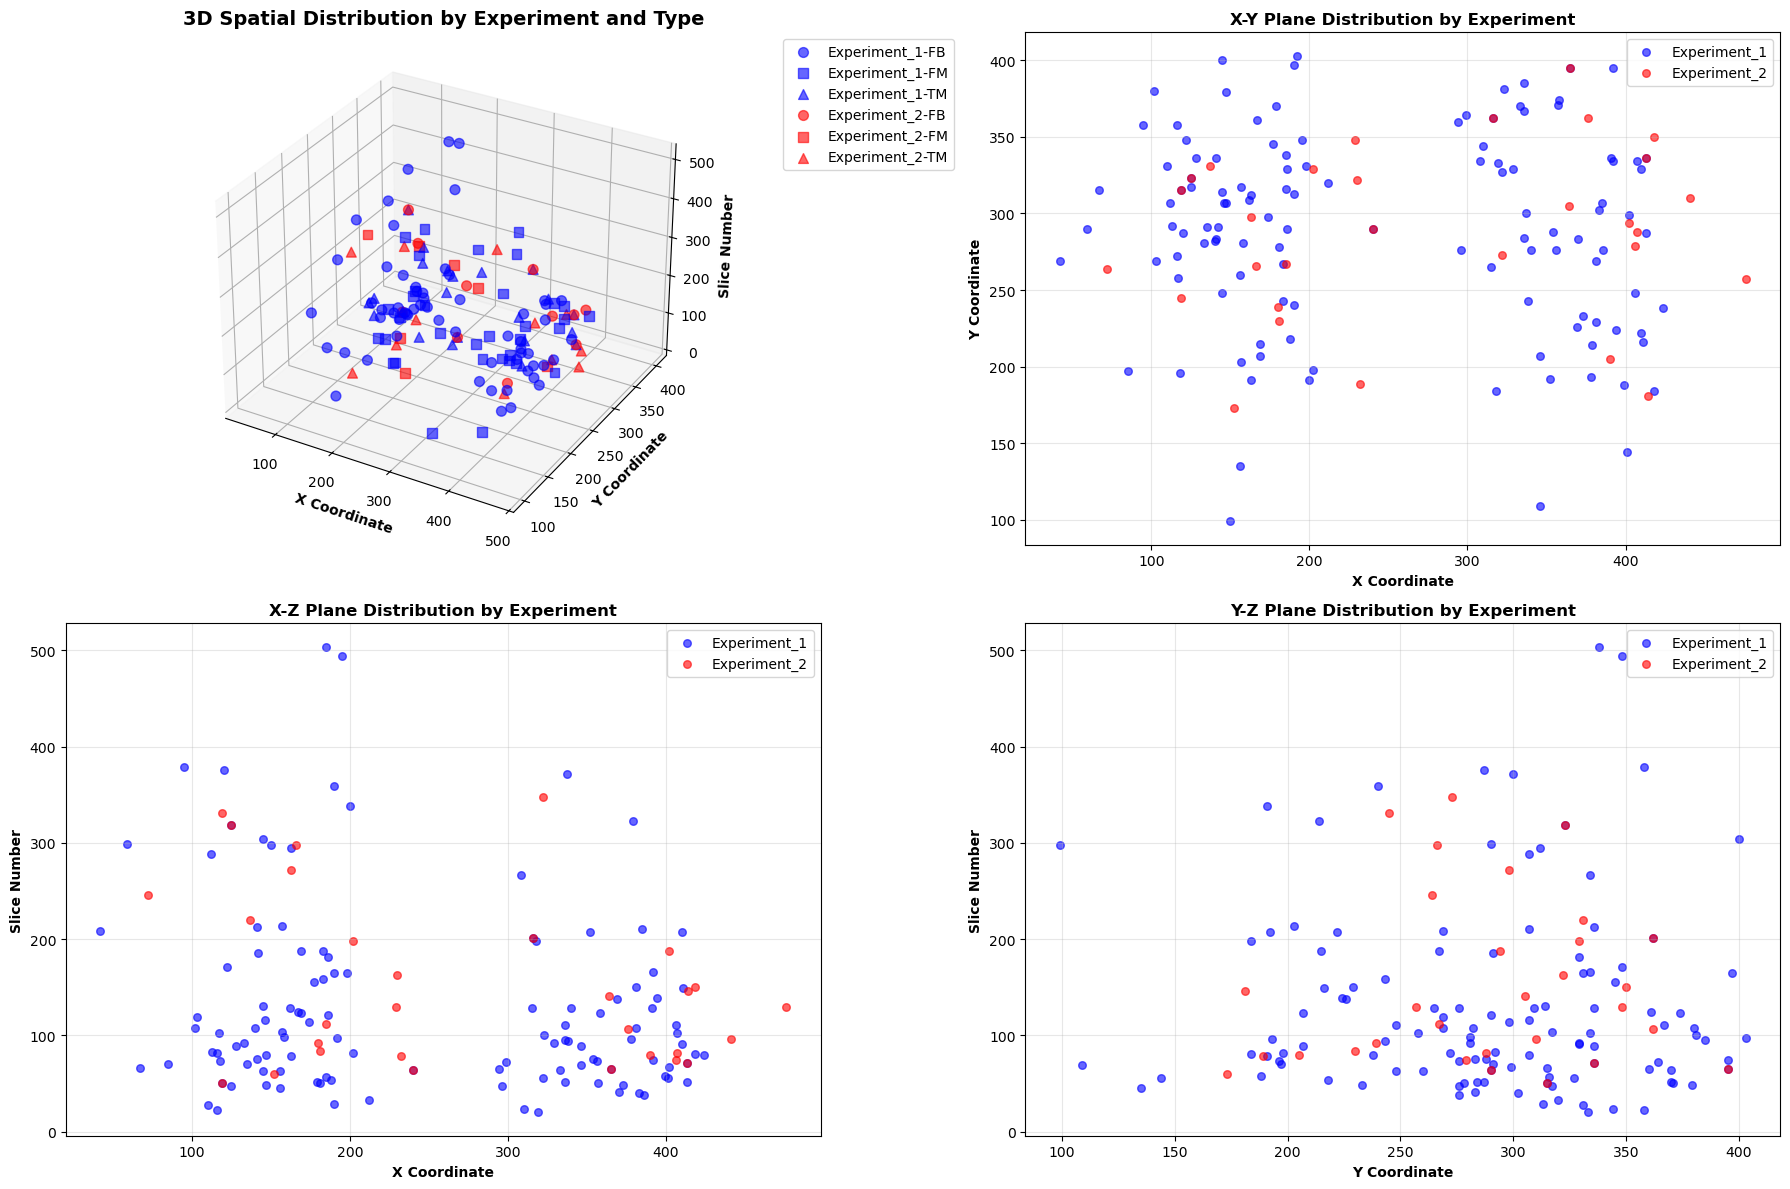


4. CORRELATION ANALYSIS


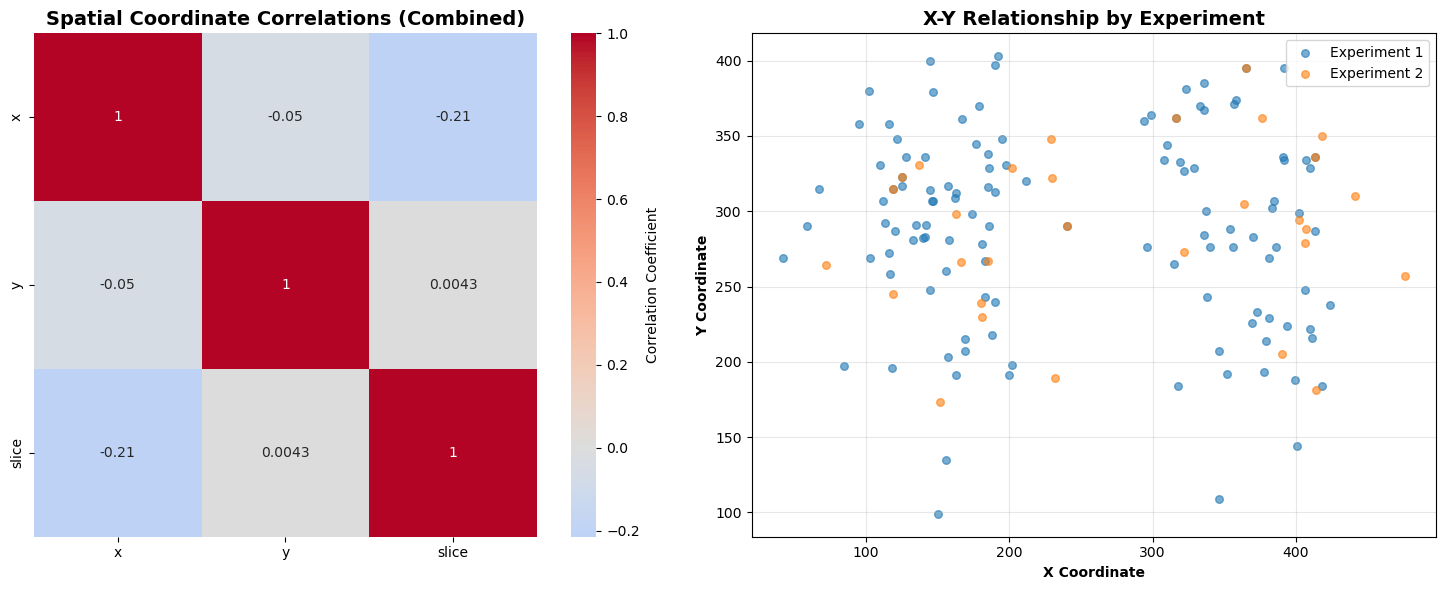


5. AUGMENTED SAMPLES VISUALIZATION


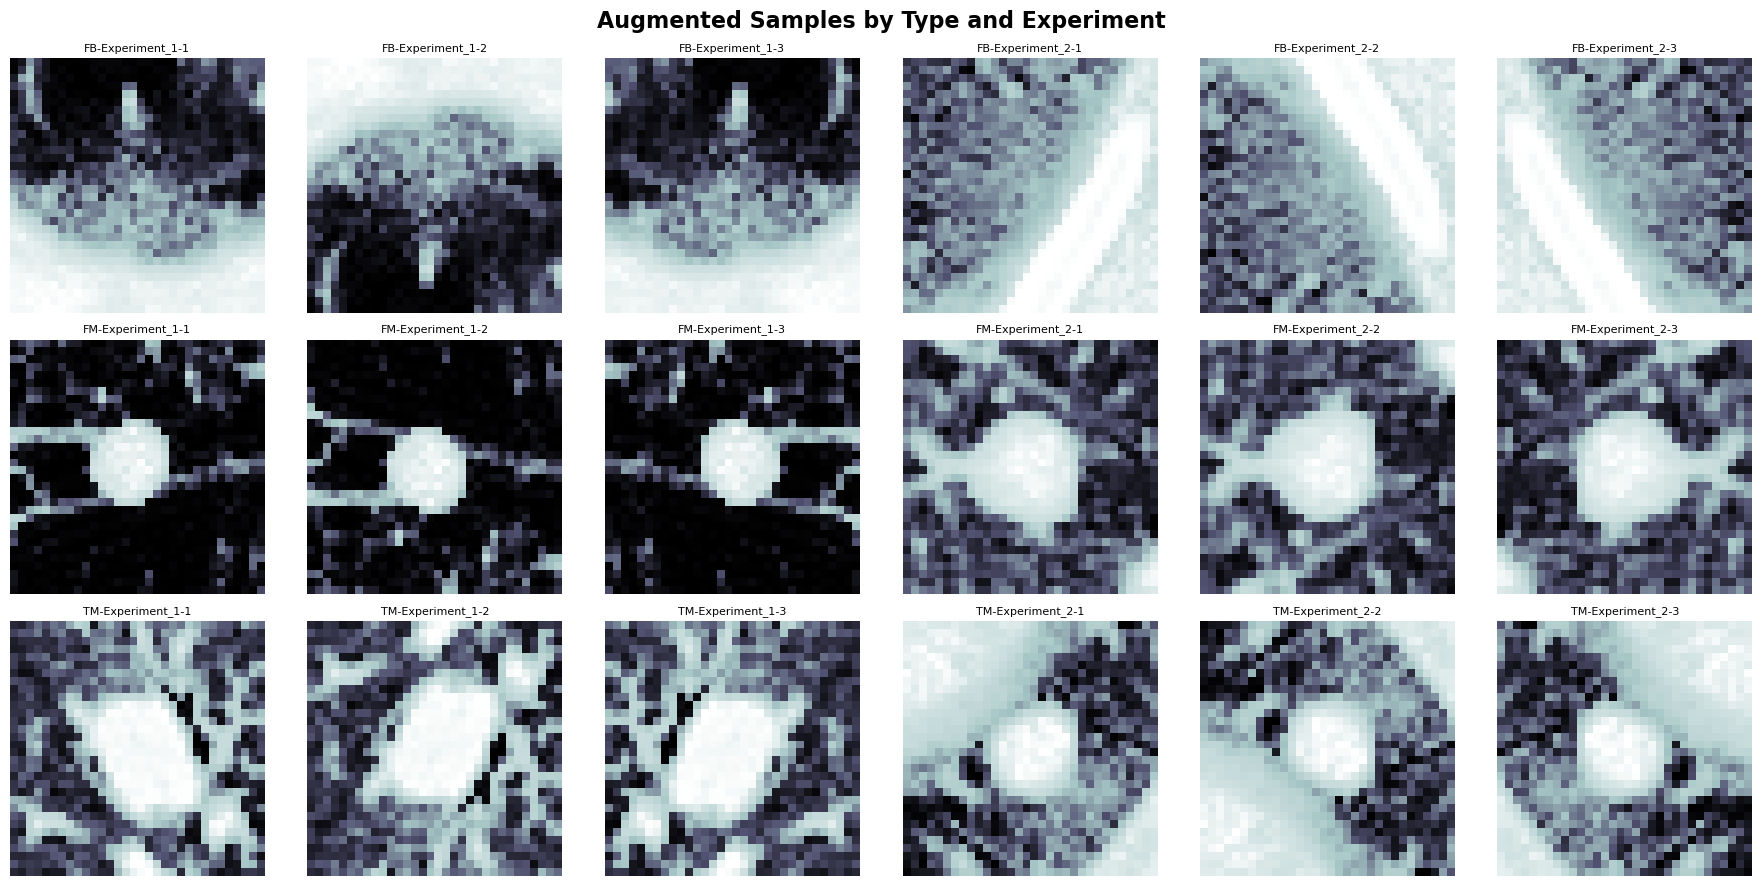


=== Augmentation Statistics ===
Total augmented samples: 1480
Samples per experiment:
  Experiment_1: 1180 samples
  Experiment_2: 300 samples

Augmentation factor per type:
  FB: 720 samples
  FM: 410 samples
  TM: 350 samples


In [7]:
if __name__ == "__main__":
    import os
    
    # Configuration
    base_path = os.path.expanduser("~/Downloads/deepfakes+medical+image+tamper+detection (1)/data/Tampered Scans/")
    
    experiments_config = [
        {
            'labels_csv': os.path.join(base_path, "labels_exp1.csv"),
            'dicom_dir': os.path.join(base_path, "Experiment 1 - Blind"),
            'experiment_name': 'Experiment_1'
        },
        {
            'labels_csv': os.path.join(base_path, "labels_exp2.csv"),
            'dicom_dir': os.path.join(base_path, "Experiment 2 - Open"),
            'experiment_name': 'Experiment_2'
        }
    ]
    
    output_dataset = "combined_tampered_scans_dataset.npy"
    
    # Run EDA
    df, label_encoder = run_combined_eda(experiments_config, output_dataset)